In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [2]:
# We suppress all warnings because some of the warnings are insignificant, 
# but they greatly damaged our ability to clearly see the results of cells.
warnings.filterwarnings('ignore')

## Topic: Social Studies with Contraceptive Data from 1987 National Indonesia Contraceptive Prevalence Survey

Taking a look at the provided dataset:

In [3]:
contraceptive_original = pd.read_csv("contraceptive_for_students.csv")
contraceptive_original.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


Questions we are trying to answer:
* 1. Among the information collected, what are the factors that best determine the number of children a woman has? Can we build a model to accurately predict this information? If so, what does this inform us about the fertility rate in society in developing countries?
* 2. What are the factors that best help to classify whether a woman is working? Can we accurately classify the employment status of a woman based on her other information? If so, what does this tell us about what encourages or discourages a woman from joining the workforce?

## Part 1: Data Cleaning/Transformation and EDA

### 1. Finding and imputing missing values

In [4]:
contraceptive_original.isnull().sum()

wife_age              0
wife_education        0
husband_education     0
num_child             0
wife_religion         0
wife_work             0
husband_occupation    0
standard_living       0
media_exposure        0
contraceptive         0
dtype: int64

This is a complete dataset with no missing values! There's nothing we need to impute.

### 2. Investigate variable types

Right now, all of our data is encoded as numerical values. However, much of the data is clearly categorical. <br>
For example, for the column of husband_occupation, it doesn't make sense for a husband to have a occupation of 2 or 3.<br>
Later, if we want to use one-hot encoding on these categorical variables, increasing the number of columns. It would add even more confusion. <br>
So we decided to change the representation of data by changing the types of categorical columns to string.

For data types, we find what each column represents on https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice. Here's the description of columns:
* 1. Wife's age (numerical)
* 2. Wife's education (categorical) 1=low, 2, 3, 4=high
* 3. Husband's education (categorical) 1=low, 2, 3, 4=high
* 4. Number of children ever born (numerical)
* 5. Wife's religion (binary) 0=Non-Islam, 1=Islam
* 6. Wife's now working? (binary) 0=Yes, 1=No
* 7. Husband's occupation (categorical) 1, 2, 3, 4
* 8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high
* 9. Media exposure (binary) 0=Good, 1=Not good
* 10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term

However, for some of the columns, this description is also very vague. For example, we still don't know what 1,2,3,4 in "husband's occuption" means. So I digged into the original questionaire to find information needed to transform our data. (Link for original questionaire: https://microdata.worldbank.org/index.php/catalog/1398/related-materials)

In [5]:
def transform_data(table):
    table = table.replace({'wife_education': {1: "Primary School", 2: "Junior High",
                                              3: "Senior High", 4: "Academy"}})
    table = table.replace({'husband_education': {1: "Primary School", 2: "Junior High",
                                              3: "Senior High", 4: "Academy"}})
    table = table.replace({'wife_religion': {0: "Non-Islam",1: "Islam"}})
    table = table.replace({'wife_work': {0: "Yes", 1: "No"}})
    table = table.replace({'husband_occupation': {1: "Professional, Technical and Clerical",
                                                  2: "Sales, Services",
                                                  3: "Manual", 
                                                  4: "Agriculture"}})
    table = table.replace({'standard_living': {1: "Very Low", 2: "Low", 3: "Medium", 4: "High"}})
    table = table.replace({'media_exposure': {0: "Good", 1: "Not Good"}})
    table = table.replace({'contraceptive': {1: "No-use", 2: "Long-term", 3: "Short-term"}})
    return table

contraceptive = transform_data(contraceptive_original)
contraceptive.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,Junior High,Senior High,3,Islam,No,"Sales, Services",Medium,Good,No-use
1,45,Primary School,Senior High,10,Islam,No,Manual,High,Good,No-use
2,43,Junior High,Senior High,7,Islam,No,Manual,High,Good,No-use
3,42,Senior High,Junior High,9,Islam,No,Manual,Medium,Good,No-use
4,36,Senior High,Senior High,8,Islam,No,Manual,Low,Good,No-use


### 3. Digging into the data

We want to understand our sample better by taking a look at the distributions of some column variables.

[Text(0.5, 0, 'Ages of Women'),
 Text(0.5, 1.0, "Box Plot of Women's Ages in Our Sample")]

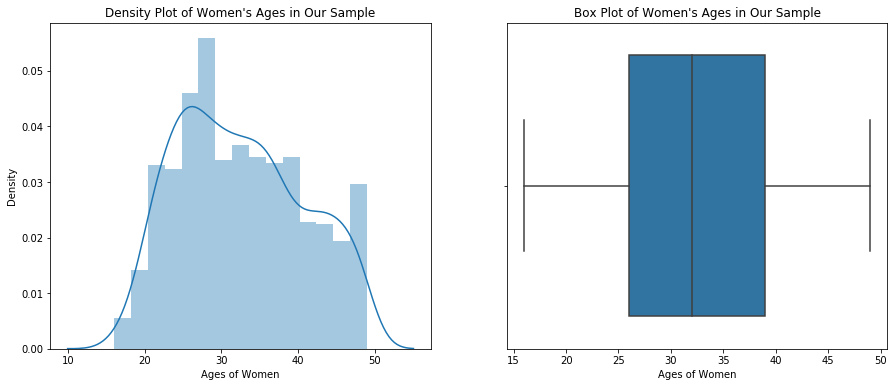

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2,)
fig.set_size_inches(15, 6)
sns.distplot(contraceptive["wife_age"], ax=ax1)
sns.boxplot(contraceptive["wife_age"], ax=ax2)
ax1.set(xlabel='Ages of Women', ylabel='Density', title = "Density Plot of Women's Ages in Our Sample")
ax2.set(xlabel='Ages of Women', title = "Box Plot of Women's Ages in Our Sample")

As we can see from the plots above, our sample only includes women from ages of 15 to 49. And majority of them are in the ages of 20-40.

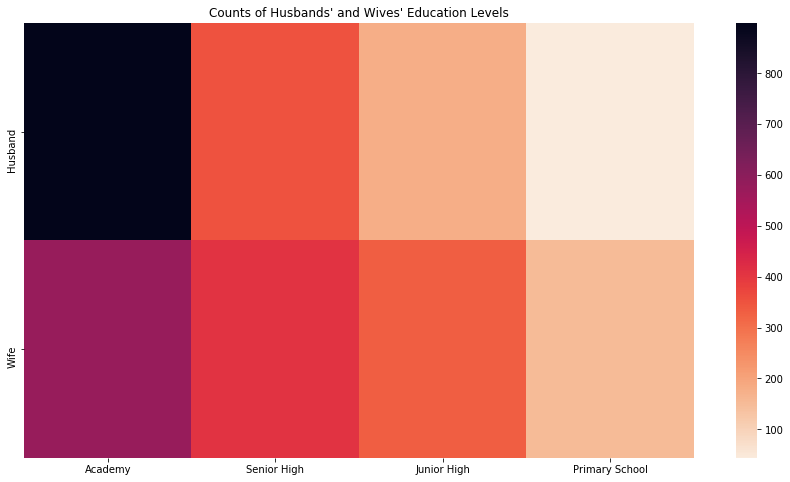

In [7]:
edu_level = ["Academy", "Senior High", "Junior High", "Primary School"]
husband_edu = contraceptive.sort_values('husband_education').groupby('husband_education').size().reindex(edu_level)
wife_edu = contraceptive.sort_values('wife_education').groupby('wife_education').size().reindex(edu_level)
plt.figure(figsize=(15,8))
plot = sns.heatmap([husband_edu, wife_edu], cmap = sns.cm.rocket_r, 
                   xticklabels=edu_level, yticklabels=['Husband', 'Wife'])
plot.set(title = "Counts of Husbands' and Wives' Education Levels")
plt.show()

This is a heatplot that shows us the education levels of husbands and wives in our sample. We can see clearly that in higher education (Academy), there are higher concentrations of husbands than wives, while the contrary is true for below-Academy-level education. However, for both husbands and wvies in our sample, the majority of them receive education more advanced than junior high. The average education level of people in our sample is high.

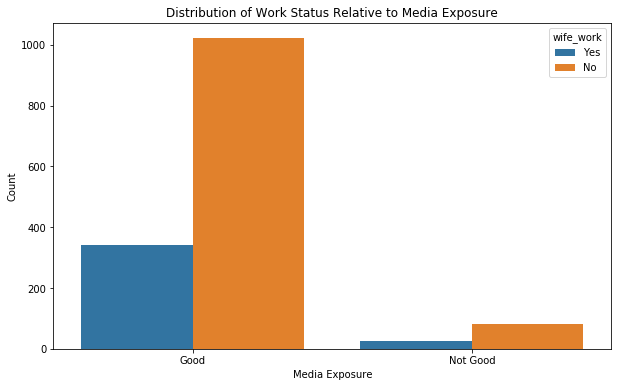

In [8]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="media_exposure", hue="wife_work", hue_order=['Yes', 'No'], data=contraceptive)
ax.set(xlabel = "Media Exposure", ylabel='Count', title = "Distribution of Work Status Relative to Media Exposure")
plt.show()

From this histogram, we can see that in our sample, the vast majority of women don't work, and have good media exposure. Noticeably, for women that have good media exposure, most of them still choose to not to work. Does this mean that exposure to media is not a beneficial factor in classifying whether a woman works? 

[Text(0.5, 0, 'Number of Children a Woman Has'),
 Text(0.5, 1.0, 'Box Plot of Number of Children Women Have in Our Sample')]

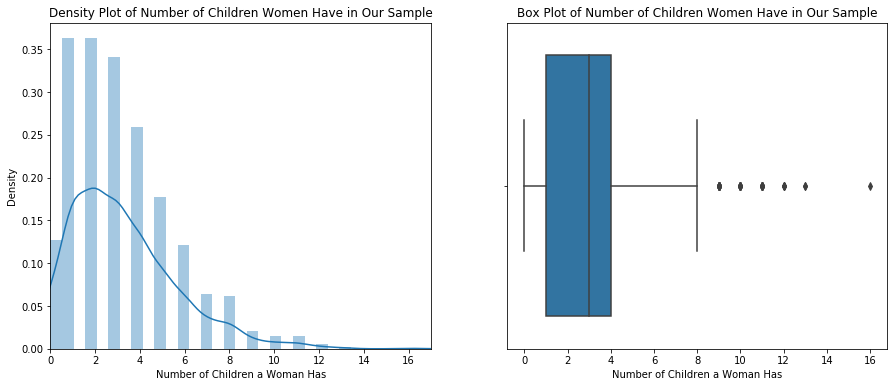

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2,)
fig.set_size_inches(15, 6)
sns.distplot(contraceptive["num_child"], ax=ax1)
sns.boxplot(contraceptive["num_child"], ax=ax2)
ax1.set(xlim=(0, 17), xlabel='Number of Children a Woman Has', ylabel='Density', title = "Density Plot of Number of Children Women Have in Our Sample")
ax2.set(xlabel='Number of Children a Woman Has', title = "Box Plot of Number of Children Women Have in Our Sample")

From these two plots, we can see that majority of women in our sample have less than 5 children. The density plot is right skewed. And the woman with the most number of children in our sample has as many as 16 children! 

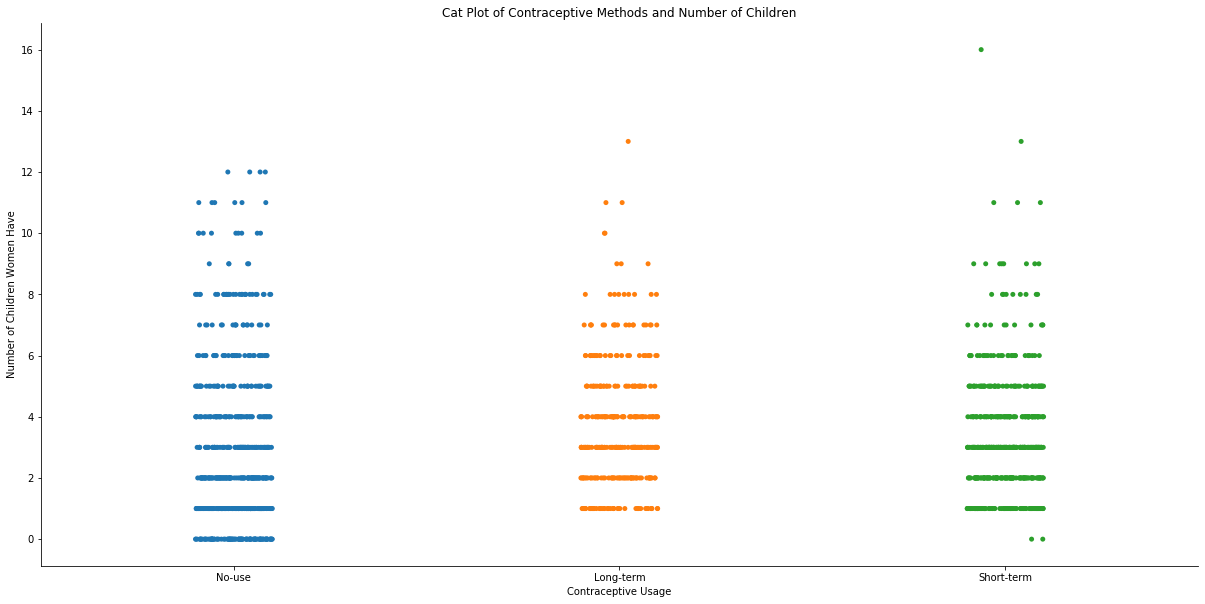

In [10]:
ax = sns.catplot(x="contraceptive", y="num_child", data=contraceptive, height=8.27, aspect=8.7/4.27)
ax.set(ylabel = "Number of Children Women Have", xlabel="Contraceptive Usage", title="Cat Plot of Contraceptive Methods and Number of Children")

Interestingly, in our sample, not using contraceptive methods doesn't seem to result in having more children. Noticeably, for the women who have no children, most of them don't use any contraceptive methods. It might be possible that women who don't use contraceptive methods don't plan on having children in the first place. It seems that the distribution of number of children is very similar in all three cases of contraceptive methods. Contraceptive method may not be an important factor in predicting the number of children.

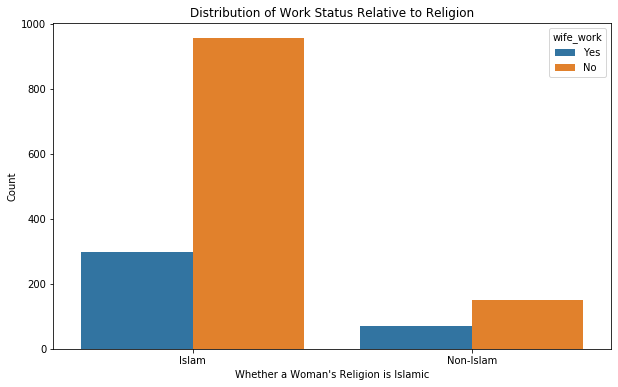

In [11]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="wife_religion", hue="wife_work", hue_order=['Yes', 'No'], data=contraceptive)
ax.set(xlabel = "Whether a Woman's Religion is Islamic", ylabel='Count', title = "Distribution of Work Status Relative to Religion")
plt.show()

From this plot, we can see that most of women in our dataset are Islamic women. At this point, we can see that in terms of media exposure, education level, religious belief and working status, the distribution of women in our sample is not very balanced. Still, from the above plot, it seems that non-Islamic women are more likely to work than Islamic women. Religion may later turns out to be a beneficial factor in predicting work statuses of women.

Let's take a look at the last two unexplored columns in our dataset. In Indonesia in 1987, how does husband's occuption relate to standard of living?

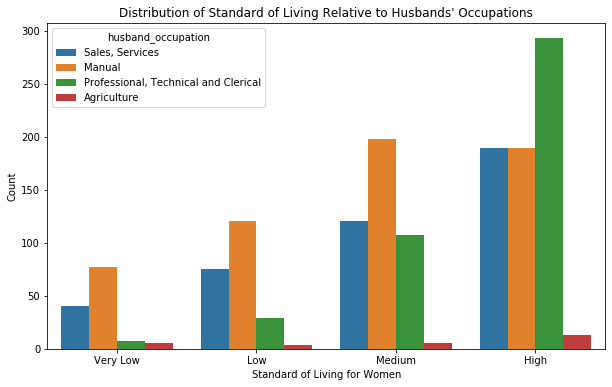

In [12]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="standard_living", order=['Very Low', 'Low', 'Medium', 'High'], 
                   hue="husband_occupation", data=contraceptive)
ax.set(xlabel = "Standard of Living for Women", ylabel='Count', title = "Distribution of Standard of Living Relative to Husbands' Occupations")
plt.show()

From this plot, it seems that living standard may relate to husbands' occuption. As women with high living standards often have husbands that do professional, technical and clerical work. Also, except in women who have high living standards, all other women are most likely to married to husbands that do manual work. Later, we can explore using these two varibales to predict number of children, and classify women's work status.

### 4. Principal Component Analysis

To further explore our data, we want to do a principal component analysis to see what a 2D version of our data looks like and whether there are trends or clustering. However, since our table mostly consists of categorical variables. We need to do one-hot encoding first.

In [13]:
contraceptive_encoded = pd.get_dummies(contraceptive, columns = ['wife_education', 'husband_education','wife_religion','wife_work','husband_occupation','standard_living','media_exposure','contraceptive'], drop_first=True)
contraceptive_encoded.head()

,wife_age,num_child,wife_education_Junior High,wife_education_Primary School,wife_education_Senior High,husband_education_Junior High,husband_education_Primary School,husband_education_Senior High,wife_religion_Non-Islam,wife_work_Yes,husband_occupation_Manual,"husband_occupation_Professional, Technical and Clerical","husband_occupation_Sales, Services",standard_living_Low,standard_living_Medium,standard_living_Very Low,media_exposure_Not Good,contraceptive_No-use,contraceptive_Short-term
0,24,3,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0
1,45,10,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
2,43,7,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
3,42,9,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0
4,36,8,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0


Now, let's follow the steps to do a PCA. First we center and rescale the data.

In [14]:
contraceptive_centered = contraceptive_encoded - np.mean(contraceptive_encoded, axis=0)
contraceptive_centered_scaled = contraceptive_centered/np.std(contraceptive_centered, axis=0)
contraceptive_centered_scaled.head()

,wife_age,num_child,wife_education_Junior High,wife_education_Primary School,wife_education_Senior High,husband_education_Junior High,husband_education_Primary School,husband_education_Senior High,wife_religion_Non-Islam,wife_work_Yes,husband_occupation_Manual,"husband_occupation_Professional, Technical and Clerical","husband_occupation_Sales, Services",standard_living_Low,standard_living_Medium,standard_living_Very Low,media_exposure_Not Good,contraceptive_No-use,contraceptive_Short-term
0,-1.038167,-0.110856,1.846667,-0.339211,-0.621048,-0.370745,-0.175473,1.784561,-0.419021,-0.578134,-0.811655,-0.648416,1.570313,-0.429050,1.554874,-0.30981,-0.282687,1.158366,-0.728824
1,1.515194,2.858078,-0.541516,2.948014,-0.621048,-0.370745,-0.175473,1.784561,-0.419021,-0.578134,1.232051,-0.648416,-0.636816,-0.429050,-0.643139,-0.30981,-0.282687,1.158366,-0.728824
2,1.272017,1.585678,1.846667,-0.339211,-0.621048,-0.370745,-0.175473,1.784561,-0.419021,-0.578134,1.232051,-0.648416,-0.636816,-0.429050,-0.643139,-0.30981,-0.282687,1.158366,-0.728824
3,1.150428,2.433945,-0.541516,-0.339211,1.610181,2.697273,-0.175473,-0.560362,-0.419021,-0.578134,1.232051,-0.648416,-0.636816,-0.429050,1.554874,-0.30981,-0.282687,1.158366,-0.728824
4,0.420897,2.009811,-0.541516,-0.339211,1.610181,-0.370745,-0.175473,1.784561,-0.419021,-0.578134,1.232051,-0.648416,-0.636816,2.330733,-0.643139,-0.30981,-0.282687,1.158366,-0.728824


In [15]:
u, s, vt = np.linalg.svd(contraceptive_centered_scaled, full_matrices=False)
pcs = contraceptive_centered_scaled @ vt.T
pcs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.619015,-0.911310,1.742360,1.228025,-0.260085,2.709890,-0.225123,-0.182284,-0.722958,1.271798,-0.189412,-1.059472,-0.233629,-0.336993,0.031341,-0.416371,0.401101,0.065841,-0.025867
1,2.399024,1.521437,-1.511968,-0.344826,2.498409,1.192370,0.945120,-0.139103,0.459986,-0.236554,0.297406,-1.105743,2.446220,0.274512,-0.019549,-0.653172,1.242644,-0.162569,-0.018706
2,1.510894,-0.120046,-0.223152,-0.606065,0.848507,2.620532,2.142272,-0.299509,0.724311,-0.118885,-0.271435,-0.268167,0.458048,0.516280,-0.745224,-0.081073,0.415068,0.145501,0.000092
3,1.475263,0.526859,-0.970159,-0.658352,1.758977,1.564036,-0.584061,0.187222,-1.843043,-2.608583,-0.147339,1.999645,-0.152207,-0.603528,-0.141322,-0.245342,0.324925,0.911667,0.043485
4,1.327392,-0.698772,0.011778,0.266307,2.955554,-0.135735,2.757444,-0.235422,-0.602696,-0.601243,-0.499395,0.493475,0.230687,-0.278603,0.676588,-0.275791,0.597221,0.586103,0.050028


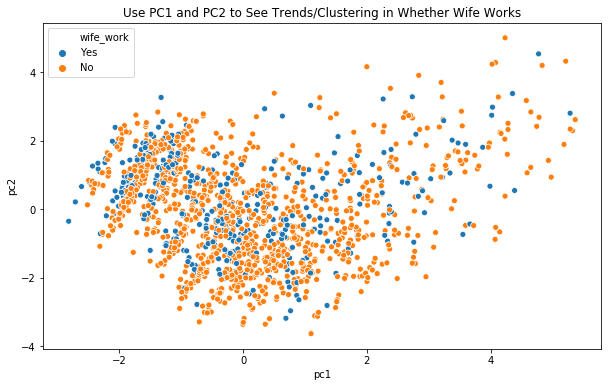

In [16]:
plt.figure(figsize=(10,6))
fst_2_pcs = pcs.iloc[:,0:2]
fst_2_pcs = fst_2_pcs.rename(columns={0:"pc1", 1:"pc2"})
fst_2_pcs["wife_work"] = contraceptive["wife_work"]
pcplot1 = sns.scatterplot(data = fst_2_pcs, x = "pc1", y = "pc2", hue="wife_work", hue_order=['Yes', 'No'])
pcplot1.set(title="Use PC1 and PC2 to See Trends/Clustering in Whether Wife Works")
plt.show()

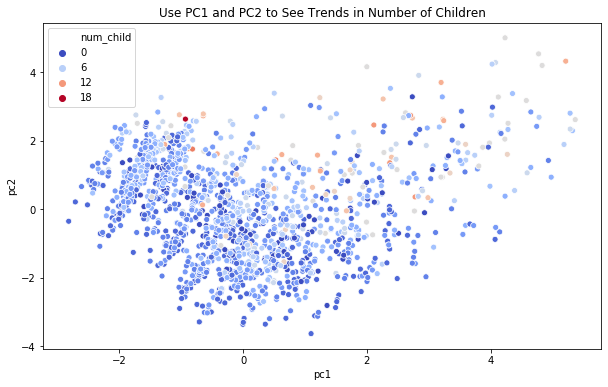

In [17]:
plt.figure(figsize=(10,6))
fst_2_pcs["num_child"] = contraceptive["num_child"]
pcplot2 = sns.scatterplot(data = fst_2_pcs, x = "pc1", y = "pc2", hue="num_child", palette = "coolwarm")
pcplot2.set(title="Use PC1 and PC2 to See Trends in Number of Children")
plt.show()

We extracted the first two principal components, and plot them with a scatterplot to see whether there are trends/clustering with the variables we are trying to classify and predict. However, it seems that we couldn't see any trends/clustering. We plotted a scree plot below. It turns out the first two principal components are capturing less than 1/4 of the variances. This might be the reason that we can hardly observe any useful information in our scatterplots.

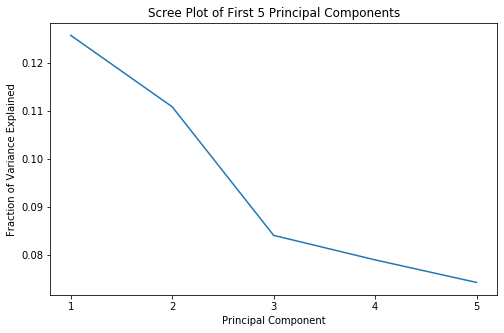

In [18]:
fig = plt.figure(figsize=(8,5))
variances = (s**2 / sum(s**2))[0:5]
sns.lineplot(np.arange(1, 6), variances)
plt.xticks([1, 2, 3, 4, 5], [1, 2, 3, 4, 5]);
plt.title('Scree Plot of First 5 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Fraction of Variance Explained')
plt.show()

## Part 2: Predicting the Numer of Children a Woman Has

### 1. Train test split and error definition

Now, let's move on to predict the number of children with other information about the woman. We decided to use a linear regression model. First, let's split the data into train and test sets.

In [19]:
train, test = train_test_split(contraceptive_encoded, test_size=0.3, random_state=42)
X_train = train.drop(columns=["num_child"])
Y_train = train["num_child"]
X_test = test.drop(columns=["num_child"])
Y_test = test["num_child"]

For linear regression, we also want to define rmse to evaluate error.

In [20]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

### 2. Building a base model

To evaluate how accurate our model is, let's compare it with a base model, that always predicts the median number of children for all women. Let's look at the train error and test error of this model.

In [21]:
median_children =  Y_train.median()
median_children

3.0

In [22]:
base_model_train_predicted = np.ones(len(Y_train)) * median_children
base_model_test_predicted = np.ones(len(Y_test)) * median_children
base_model_train_error = rmse(Y_train, base_model_train_predicted)
base_model_test_error = rmse(Y_test, base_model_test_predicted)
print("base model train error: ", base_model_train_error)
print("base model test error:", base_model_test_error)

base model train error:  2.429810017600036
base model test error: 2.2320171263878525


In [23]:
def prediction_accuracy(actual, predicted):
    return np.count_nonzero(predicted == actual)/len(actual)

In [24]:
base_model_train_accuracy = prediction_accuracy(Y_train, base_model_train_predicted)
base_model_test_accuracy = prediction_accuracy(Y_test, base_model_test_predicted)
print("base model train accuracy", base_model_train_accuracy)
print("base model test accuracy", base_model_test_accuracy)

base model train accuracy 0.1842870999030068
base model test accuracy 0.15610859728506787


For our base model that always predicts the median of train set, the train error is 2.43, and the test error is 2.23. 
Also, our base model "guesses" right 18.43% of times in the train set, and "guesses" right 15.61% of times in the test set.
These are the benchmarks for our linear model to compare against. 

### 3. Cross validation 

To select features that improve our rmse, we can use cross validation. First, let's try to examine features from left to right, we first use only the leftmost feature, then we use the first 2 features on the left etc. And we try to determine the best number of features counting from the left.<br>
After finding the optimal number of features, we then shuffle the columns, do the same process, and see whether we can find a combination of features that give a better result. We iterated this process 1000 times.<br>
We round the prediction results to its nearest integer, since it doesn't make sense to have a decimal number for number of children.

In [25]:
def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X)) ** 2))

In [26]:
def output_error_and_accuracy_with_features(selected_features):
    model = LinearRegression()
    model.fit(selected_features, Y_train)
    train_data = selected_features
    chosen = selected_features.columns.tolist()
    test_data = X_test[chosen]
    output_error_and_accuracy_with_fitted_model(model, train_data, test_data)


def output_error_and_accuracy_with_fitted_model(selected_model, train_data, test_data):
    model_train_predicted = selected_model.predict(train_data)
    model_test_predicted = selected_model.predict(test_data)
    model_train_predicted = np.rint(model_train_predicted)
    model_test_predicted = np.rint(model_test_predicted)
    model_train_error = rmse(Y_train, model_train_predicted)
    model_test_error = rmse(Y_test, model_test_predicted)
    model_train_accuracy = prediction_accuracy(Y_train, model_train_predicted)
    model_test_accuracy = prediction_accuracy(Y_test, model_test_predicted)
    print("model train error", model_train_error)
    print("model test error", model_test_error)
    print("model train accuracy", model_train_accuracy)
    print("model test accuracy", model_test_accuracy)

In [27]:
def cross_validation_with_linear(X_train):
    curr_columns = list(X_train.columns)
    best_features = X_train
    best_score = 10
    for j in np.arange(1000):
        curr_table = X_train[curr_columns]
        for i in np.arange(1, len(curr_table.columns) + 1):
            curr_features = curr_table.iloc[:, 0:i]
            curr_model = LinearRegression()
            curr_score = np.mean(cross_val_score(curr_model, curr_features, Y_train, scoring = rmse_score, cv = 5))
            if curr_score < best_score:
                best_score = curr_score
                best_features = curr_features
        random.Random(j).shuffle(curr_columns)
    return best_score, best_features

In [28]:
best_score, best_features = cross_validation_with_linear(X_train)
print("best cv score is: ", best_score)

best cv score is:  1.8815417482250691


In [29]:
output_error_and_accuracy_with_features(best_features)

model train error 1.8782020831064614
model test error 1.759910528371628
model train accuracy 0.2696411251212415
model test accuracy 0.26018099547511314


After feature selections with our linear regression, our train error and test error are much better than those of the base models. Moreover, our linear regression model "guesses" correctly for over 1/4 of the times about the number of children a woman has, which is a huge improvement from our base model. 

### 4. Regularization

To use regularization to select features, we first need to normalize our data.

In [30]:
X_train_normalized = StandardScaler().fit_transform(X_train)
X_test_normalized = StandardScaler().fit_transform(X_test)

#### Ridge regression

Let's first use ridge regression to tune our model and select features. Again, we use cross validation to evaluate erros.

In [31]:
alpha_arr = np.linspace(0, 200, 1000)
cv_errors = []
for curr_alpha in alpha_arr:
    ridge_model = Ridge(alpha = curr_alpha)
    cv_error = np.mean(cross_val_score(ridge_model, X_train_normalized, Y_train, scoring = rmse_score, cv = 5))    
    cv_errors.append(cv_error)

best_alpha_ridge = alpha_arr[np.argmin(cv_errors)]
print(f"The best alpha value is {best_alpha_ridge}")
print(f"Cross validation error for the best alpha value is {cv_errors[np.argmin(cv_errors)]}")

The best alpha value is 9.20920920920921
Cross validation error for the best alpha value is 1.8877437328527116


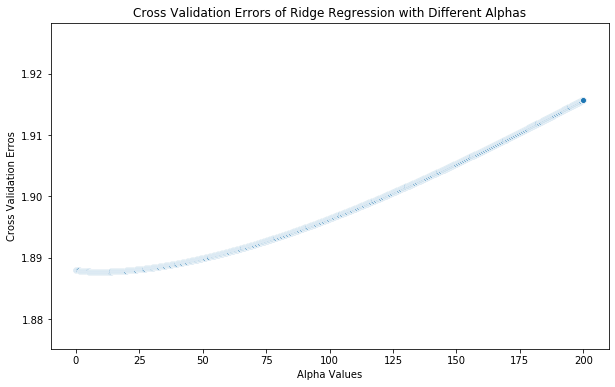

In [32]:
plt.figure(figsize=(10,6))
error_plot_ridge = sns.scatterplot(x=alpha_arr, y=cv_errors)
error_plot_ridge.set(title="Cross Validation Errors of Ridge Regression with Different Alphas", 
                     xlabel = "Alpha Values", ylabel="Cross Validation Erros")
plt.show()

In [33]:
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train_normalized, Y_train)
output_error_and_accuracy_with_fitted_model(ridge_model, X_train_normalized, X_test_normalized)

model train error 1.8769106010840495
model test error 1.7854363067412582
model train accuracy 0.27158098933074687
model test accuracy 0.26244343891402716


After model tuning, ridge regression has similar performances with our linear regression model in the previous part.

#### Lasso regression

In [34]:
alpha_arr = np.linspace(0.01, 0.5, 1000)
cv_errors = []
for curr_alpha in alpha_arr:
    lasso_model = Lasso(alpha = curr_alpha, max_iter = 1000000)
    cv_error = np.mean(cross_val_score(lasso_model, X_train_normalized, Y_train, scoring = rmse_score, cv = 5))    
    cv_errors.append(cv_error)

best_alpha_lasso = alpha_arr[np.argmin(cv_errors)]
print(f"The best alpha value is {best_alpha_lasso}")
print(f"Cross validation error for the best alpha value is {cv_errors[np.argmin(cv_errors)]}")

The best alpha value is 0.021771771771771774
Cross validation error for the best alpha value is 1.887233642361133


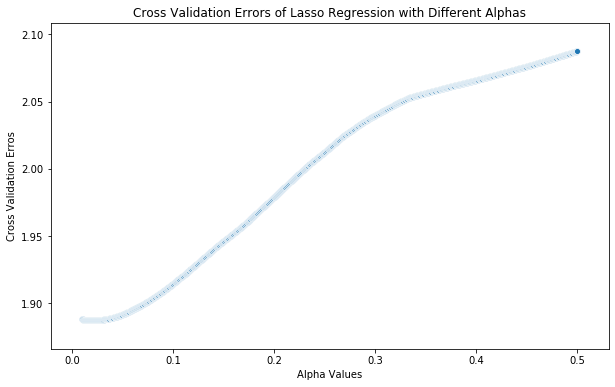

In [35]:
plt.figure(figsize=(10,6))
error_plot_lasso = sns.scatterplot(x=alpha_arr, y=cv_errors)
error_plot_lasso.set(title="Cross Validation Errors of Lasso Regression with Different Alphas", xlabel = "Alpha Values", ylabel="Cross Validation Erros")
plt.show()

In [36]:
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train_normalized, Y_train)
output_error_and_accuracy_with_fitted_model(lasso_model, X_train_normalized, X_test_normalized)

model train error 1.8838740858374823
model test error 1.7720811192529167
model train accuracy 0.26576139670223087
model test accuracy 0.2669683257918552


Comparing train and test accuracies, train and test errors of Lasso and Ridge models with our previous linear regression models, we find that the three models have very close results, and our linear regression model in part 3 is slightly better. 

### 5. Answering our first set of questions

#### Question 1: What are the factors that best determine the number of children a woman has, based on her other information? 

In [37]:
list(best_features.columns)

['standard_living_Low',
 'husband_education_Senior High',
 'contraceptive_No-use',
 'wife_education_Primary School',
 'husband_education_Junior High',
 'wife_work_Yes',
 'standard_living_Medium',
 'standard_living_Very Low',
 'wife_education_Senior High',
 'wife_religion_Non-Islam',
 'wife_education_Junior High',
 'contraceptive_Short-term',
 'wife_age']

The features selected by our best model(factors that best determine the number of childrena woman has) are:
* 1. The standard living index of a woman
* 2. Whether the husband's education level is Senior High or Junior High
* 3. The types of contraceptive methods used
* 4. The woman's education level
* 5. Whether the woman works
* 6. The woman's living standard
* 7. Whether the woman's religion is Islamic
* 8. The age of the woman 

Noticeably, features about husband's occupation or woman's media exposure are not selected.

#### Question 2: Can we build a model to accurately predict this information? 

In [38]:
output_error_and_accuracy_with_features(best_features)

model train error 1.8782020831064614
model test error 1.759910528371628
model train accuracy 0.2696411251212415
model test accuracy 0.26018099547511314


For our best model, in both the train set and the test set, we accuractely predict the exact number for 26% of women. What about the rest of the predictions? How off are they?

In [39]:
best_model = LinearRegression()
best_model.fit(best_features, Y_train)
best_model_train_predicted = best_model.predict(best_features)
chosen = best_features.columns.tolist()
best_model_test_predicted = best_model.predict(X_test[chosen])
best_model_train_predicted = np.rint(best_model_train_predicted)
best_model_test_predicted = np.rint(best_model_test_predicted)

In [40]:
offs_train = np.abs(Y_train - best_model_train_predicted)

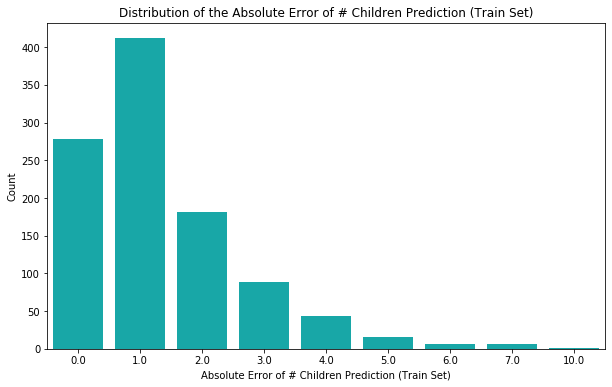

In [41]:
plt.figure(figsize=(10,6))
off_plot = sns.countplot(x=offs_train, color='c')
off_plot.set(title = "Distribution of the Absolute Error of # Children Prediction (Train Set)", 
             ylabel = 'Count', xlabel = "Absolute Error of # Children Prediction (Train Set)")
plt.show()

In [42]:
offs_test = np.abs(Y_test - best_model_test_predicted)

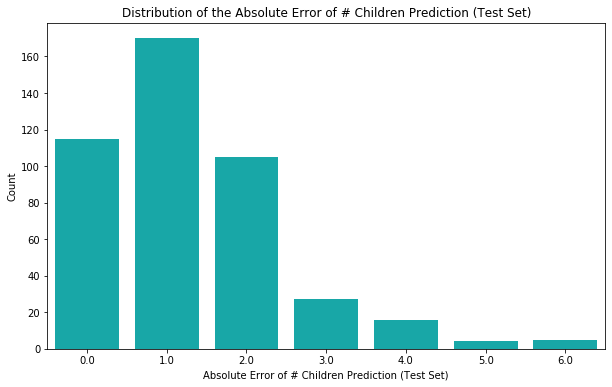

In [43]:
plt.figure(figsize=(10,6))
off_plot = sns.countplot(x=offs_test, color='c')
off_plot.set(title = "Distribution of the Absolute Error of # Children Prediction (Test Set)", 
             ylabel = 'Count', xlabel = "Absolute Error of # Children Prediction (Test Set)")
plt.show()

With our best model, we can see that the vast majority of our predictions for number of children a woman has are at most 1 off compared to the actual numbers. So we can indeed build a model to accurately predict this information.

#### Question 3: If so, what does this inform us about the fertility rate in society in developing countries?

Let's again take a look at our selected features, and compare them with the coefficients assigned to them.

In [44]:
list(best_features.columns)

['standard_living_Low',
 'husband_education_Senior High',
 'contraceptive_No-use',
 'wife_education_Primary School',
 'husband_education_Junior High',
 'wife_work_Yes',
 'standard_living_Medium',
 'standard_living_Very Low',
 'wife_education_Senior High',
 'wife_religion_Non-Islam',
 'wife_education_Junior High',
 'contraceptive_Short-term',
 'wife_age']

In [45]:
best_model.coef_

array([ 0.12676283,  0.33835043, -1.15629796,  0.8537384 ,  0.61877408,
       -0.54428521,  0.10833589,  0.40401271,  0.66304461, -0.66653734,
        0.86520186, -0.13893376,  0.16982159])

Except the last selected variable wife_age, all other variables selected have the same scale (They are either 0 or 1). Under the circumstance, we can compare their coefficients, and see their impacts to our model. Looking at the first 12 coefficients, we find that the 4th one(wife_education_primary_school) and the 11th one(wife_education_junior_high) are both over 0.85. In short, maybe whether the woman's education level is low does have an huge impact on the number of children she has? In our model, if a woman has low education level, she tends to have more children. If this is true, then the fertility rate in a society may largely be influenced by the education levels of women.

#### A/B Testing

We would like to do a A/B Testing on this issue, using a P-value of 0.01. We label primary school and junior high as low education level and senior high and academy as high education level.<br>
**Null hypothesis**: In the population, the distribution of number of children for mothers is the same for mothers who have high-level education as mothers who don't. The difference in the sample is due to chance.<br>
**Alternative hypothesis**: In the population, the number of children of the mothers who have low level eduction is more, on average, than the number of children of the mothers who have high-level education.<br>
**Test statistics**:  Average # of children of the mothers who have low education levels −  average # of children of the mothers who have high education levels

In [46]:
women_education = contraceptive[["wife_education", "num_child"]]
women_education = women_education.replace({'wife_education': {"Primary School": "Low", "Junior High": "Low",
                                                              "Senior High": "High", "Academy": "High"}})
women_education.head()

,wife_education,num_child
0,Low,3
1,Low,10
2,Low,7
3,High,9
4,High,8


In [47]:
def calculate_difference(women_education, label, group_label):
    low_education_women = women_education[women_education[group_label] == "Low"]
    high_education_women = women_education[women_education[group_label] == "High"]
    observed_difference = low_education_women[label].mean() - high_education_women[label].mean()
    return observed_difference

observed_difference = calculate_difference(women_education, "num_child", "wife_education")
observed_difference

0.7952518543535092

In [48]:
differences = np.array([])
repetitions = 5000
for i in np.arange(repetitions):
    shuffled_labels = np.random.permutation(women_education["wife_education"].values)
    women_education["shuffled_education"] = shuffled_labels
    difference = calculate_difference(women_education, "num_child", "shuffled_education")
    differences = np.append(differences, difference)

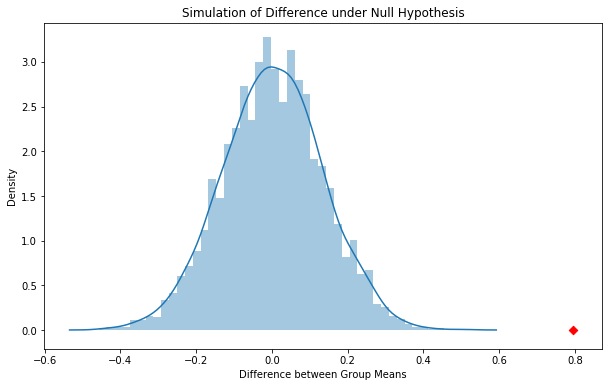

In [49]:
plt.figure(figsize=(10,6))
diff_plot = sns.distplot(differences)
diff_plot.set(xlabel='Difference between Group Means', ylabel='Density', 
              title = "Simulation of Difference under Null Hypothesis")
plt.scatter(observed_difference, 0, color='r', marker='D')
plt.show()

In [50]:
p_value = np.count_nonzero(differences[differences >= observed_difference])/len(differences)
p_value

0.0

With 5000 simulations, we have a P-value of 0, which is less than our set p-value of 0.01. So we have sufficient evidence to reject the null hypothesis. 

***As a conclusion, we realize that having a low level education is related to a woman giving birth to more children. And knowing the education level of a woman is beneficial for predicting her number of children. On a broad level, for developing countries, as the education levels of women improve, fertility rate is likely to drop. For countries that want to  reduce population pressure on environment and society, improving the education levels of women may be a good way.***

#### Furture work

In [51]:
list(best_features.columns)

['standard_living_Low',
 'husband_education_Senior High',
 'contraceptive_No-use',
 'wife_education_Primary School',
 'husband_education_Junior High',
 'wife_work_Yes',
 'standard_living_Medium',
 'standard_living_Very Low',
 'wife_education_Senior High',
 'wife_religion_Non-Islam',
 'wife_education_Junior High',
 'contraceptive_Short-term',
 'wife_age']

In [52]:
best_model.coef_

array([ 0.12676283,  0.33835043, -1.15629796,  0.8537384 ,  0.61877408,
       -0.54428521,  0.10833589,  0.40401271,  0.66304461, -0.66653734,
        0.86520186, -0.13893376,  0.16982159])

Taking a look again at the selected features and the coefficients, we see that not using any contraceptive methods seems to decrease the number of children a woman has a lot. This may seem counter-intuitive. But previously, when doing EDA, we made this plot:

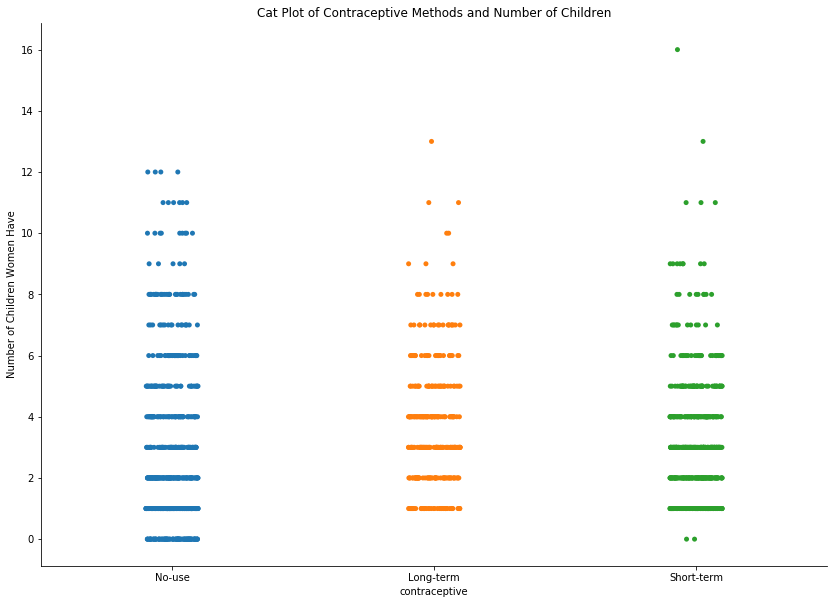

In [53]:
ax = sns.catplot(x="contraceptive", y="num_child", data=contraceptive, height=8.27, aspect=11.7/8.27)
ax.set(ylabel = "Number of Children Women Have", title="Cat Plot of Contraceptive Methods and Number of Children")

And we found that for most of the women not having any children, they don't use any contraceptive methods. This might be why not using contraceptive method helps us to predict number of children in our model. However, we still don't understand why women with contraceptive methods don't tend to have more children than women who do. What roles do contracpetive methods play in determining the number of children a woman has? What is the societal implication behind this? These all require future work to further explore.

## Part 3: Classifying whether a woman is in the workforce

### 1. Train test split

Now, let's move on to classify whether a woman is employed based on her other information. We decided to try a logistical regression model first. As always, let's first split the data into train and test.

In [54]:
train, test = train_test_split(contraceptive_encoded, test_size=0.3, random_state=42)
X_train = train.drop(columns=["wife_work_Yes"])
Y_train = train["wife_work_Yes"]
X_test = test.drop(columns=["wife_work_Yes"])
Y_test = test["wife_work_Yes"]

In [55]:
def prediction_accuracy(actual, predicted):
    return np.count_nonzero(predicted == actual)/len(actual)

### 2. Building a base model

When we were doing EDA previously, we noticed that majority of women don't work. A good base model would be a model that always predicts that a woman doesn't work. For evaluating accuracy, we can use the predicion_accuracy() function defined in the previous part.

In [56]:
base_model_train_predicted = np.zeros(len(Y_train))
base_model_test_predicted = np.zeros(len(Y_test))
base_model_train_accuracy = prediction_accuracy(Y_train, base_model_train_predicted)
base_model_test_accuracy = prediction_accuracy(Y_test, base_model_test_predicted)
print("base model train accuracy: ", base_model_train_accuracy)
print("base model test accuracy: ", base_model_test_accuracy)

base model train accuracy:  0.7449078564500485
base model test accuracy:  0.7601809954751131


Our base model has over 70% accuracy for predicting whether a woman is employed. Let's see whether our Logistic regression model can beat it.

### 3. Cross validation

We use the same cross validation process to select features as we did for linear regression.

In [57]:
def cross_validation_logistic_score(model, X, y):  
    return prediction_accuracy(y, model.predict(X))

In [58]:
def cross_validation_with_logistic(X_train):
    curr_columns = list(X_train.columns)
    best_features = X_train
    best_score = 0
    for j in np.arange(100):
        curr_table = X_train[curr_columns]
        for i in np.arange(1, len(curr_table.columns) + 1):
            curr_features = curr_table.iloc[:, 0:i]
            curr_model = LogisticRegression(max_iter=1000000)
            curr_score = np.mean(cross_val_score(curr_model, curr_features, Y_train, scoring = cross_validation_logistic_score, cv = 5))
            if curr_score > best_score:
                best_score = curr_score
                best_features = curr_features
        random.Random(j).shuffle(curr_columns)
    return best_score, best_features

In [59]:
best_score, best_features = cross_validation_with_logistic(X_train)
print("best cv score is: ", best_score)

best cv score is:  0.7468505229585853


In [60]:
def output_error_with_features(selected_features, X_test):
    model = LogisticRegression(max_iter=1000000)
    model.fit(selected_features, Y_train)
    chosen = selected_features.columns.tolist()
    train_data = selected_features
    test_data = X_test[chosen]
    output_error_and_accuracy_with_fitted_model(model, train_data, test_data)
    
    
def output_error_and_accuracy_with_fitted_model(selected_model, train_data, test_data):
    model_train_predicted = selected_model.predict(train_data)
    model_test_predicted = selected_model.predict(test_data)
    model_train_accuracy = prediction_accuracy(Y_train, model_train_predicted)
    model_test_accuracy = prediction_accuracy(Y_test, model_test_predicted)
    print("model train accuracy:", model_train_accuracy)
    print("model test accuracy:", model_test_accuracy)

In [61]:
output_error_with_features(best_features, X_test)

model train accuracy: 0.7449078564500485
model test accuracy: 0.7624434389140271


Noticeably, our logistic regression model has no noticable improvement to the base model. To improve accuracy, we would like to tune our logistic model.

### 4. Tuning logistic model with regularization 

To further tune the model, we decide to adjust the paramter C for regularization. The C parameter determines how strong we want our regularization to be. Trying different Cs may give us better results.

For logistic regression in sknlearn, we can adjust paramter C for regularization.

In [62]:
c_arr = np.linspace(0.01, 10, 500)
cv_accuracies = []
for c in c_arr:
    logistic_model = LogisticRegression(C = c, max_iter=1000000)
    cv_accuracy = np.mean(cross_val_score(logistic_model, best_features, Y_train, scoring = cross_validation_logistic_score, cv = 5))    
    cv_accuracies.append(cv_accuracy)
best_c_logistic = c_arr[np.argmax(cv_accuracies)]
print(f"The best C value is {best_c_logistic}")
print(f"Cross validation error for the best C value is {cv_accuracies[np.argmax(cv_accuracies)]}")

The best C value is 1.1111022044088177
Cross validation error for the best C value is 0.7478213967449931


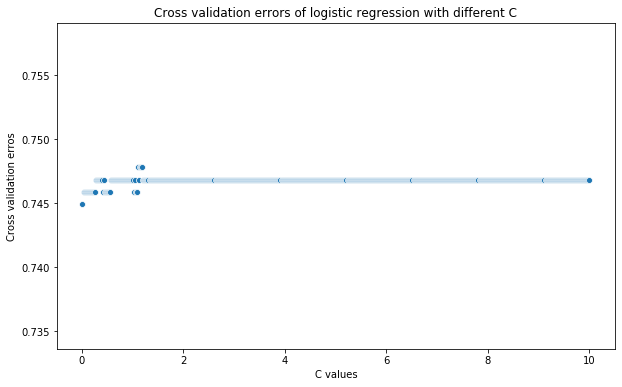

In [63]:
plt.figure(figsize=(10,6))
acc_plot_logistic = sns.scatterplot(x=c_arr, y=cv_accuracies)
acc_plot_logistic.set(title="Cross validation errors of logistic regression with different C", xlabel = "C values", ylabel="Cross validation erros")
plt.show()

In [64]:
best_logistic_model = LogisticRegression(C = best_c_logistic, max_iter=1000000)
best_logistic_model.fit(best_features, Y_train)
chosen = list(best_features.columns)
X_test_chosen = X_test[chosen]
output_error_and_accuracy_with_fitted_model(best_logistic_model, best_features, X_test_chosen)

model train accuracy: 0.7449078564500485
model test accuracy: 0.7624434389140271


With regularization, our model still has no improvement! The reason behind this is because the default value for C in our model is 1. And the best value for C from our cross valiation process is indeed around 1. So the default value for paramter C is already the best value. Noticably, when C is really low(regularization is strong), the CV accuracy becomes lowest. This shows us that there isn't much overfitting for our model, so stronger regularization doesn't really help.

### 5. Precision and recall

In [65]:
cnf_matrix = confusion_matrix(Y_test, best_logistic_model.predict(X_test_chosen))

In lab 10, we have a plot_confusion_matrix function. I copied it here to see what our confusion matrix looks like.

In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[336   0]
 [105   1]]


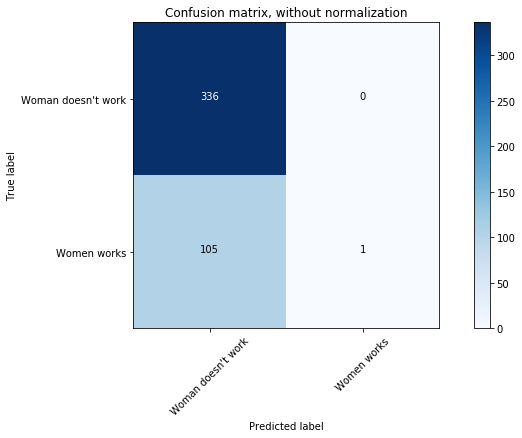

In [67]:
class_names = ["Woman doesn't work", 'Women works']
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [68]:
Y_test_predicted = best_logistic_model.predict(X_test_chosen) 
true_positives = np.count_nonzero((Y_test_predicted == Y_test) & (Y_test_predicted == 1))
false_positives = np.count_nonzero((Y_test_predicted != Y_test) & (Y_test_predicted == 1))
false_negatives = np.count_nonzero((Y_test_predicted != Y_test) & (Y_test_predicted == 0))
recall = 0
precision = 0
if true_positives + false_positives != 0:
    precision = true_positives / (true_positives + false_positives)
if true_positives + false_negatives != 0:
    recall = true_positives / (true_positives + false_negatives)
print(f'precision = {precision:.4f}')
print(f'recall = {recall:.4f}')

precision = 1.0000
recall = 0.0094


For the test set, we have 1 for precision and 0.0094 for recall.(**When run on differnt severs, sometimes the recall becomes 0 due to computational differences after the 5th decimal number when selecting features using cross validation. The results when run on Data100.datahub.berkeley.edu and datahub.berkeley.edu are not the same. But the slight difference doesn't in any way influence our analysis and conclusion**) Looking at the graph, our logistic regression model’s behavior is almost the same as our base model. There are almost not any positives in our predictions, meaning almost no true positive, false positive or false negative. So evaluating precision and recall here is meaningless.

### 6. Decision tree

One model we can try is decision tree.

In [69]:
decision_tree_model = tree.DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [70]:
output_error_and_accuracy_with_fitted_model(decision_tree_model, X_train, X_test)

model train accuracy: 0.9864209505334627
model test accuracy: 0.6380090497737556


Our decision tree has much better train accuracy, yet its test accuracy is worse. It seems that our decision tree model is overfitting on the data. To tune our decision tree model, we can try to prune the tree.

In [71]:
depths = np.arange(1, 100, 2)
cv_accuracies = []
for depth in depths:
    decision_tree_model = tree.DecisionTreeClassifier(random_state=42, max_depth = depth)
    cv_accuracy = np.mean(cross_val_score(decision_tree_model, X_train, Y_train, scoring = cross_validation_logistic_score, cv = 5))    
    cv_accuracies.append(cv_accuracy)
best_depth = depths[np.argmax(cv_accuracies)]
print(f"The best depth value is {best_depth}")
print(f"Cross validation accuracy for the best depth is {cv_accuracies[np.argmax(cv_accuracies)]}")

The best depth value is 1
Cross validation accuracy for the best depth is 0.7449087753857699


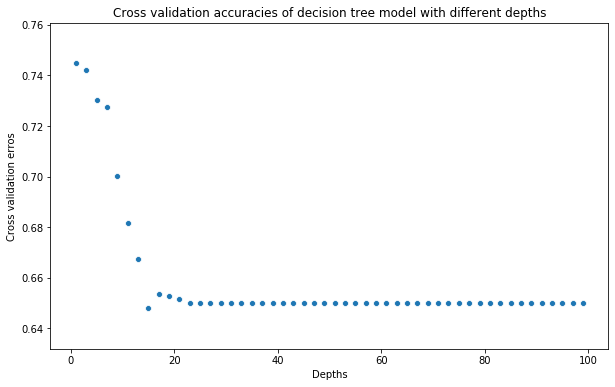

In [72]:
plt.figure(figsize=(10,6))
acc_plot_decision = sns.scatterplot(x=depths, y=cv_accuracies)
acc_plot_decision.set(title="Cross validation accuracies of decision tree model with different depths", xlabel = "Depths", ylabel="Cross validation erros")
plt.show()

In [73]:
decision_tree_model = tree.DecisionTreeClassifier(random_state=42, max_depth = best_depth )
decision_tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [74]:
output_error_and_accuracy_with_fitted_model(decision_tree_model, X_train, X_test)

model train accuracy: 0.7449078564500485
model test accuracy: 0.7601809954751131


When we prune our tree to find the best cross validation scores, we find that we get the best score when the tree has only depth 1. However, at this level, our model's performances still have no improvement from our base model. So we would like to try one last model: Random forest.

### 7. Random Forest

In [75]:
random_forest_model = ensemble.RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [76]:
output_error_and_accuracy_with_fitted_model(random_forest_model, X_train, X_test)

model train accuracy: 0.9864209505334627
model test accuracy: 0.7239819004524887


Noticably, without any adjustment of paramters, our random forest model has much higher test accuracy than decision tree model while still maintaining a high test accuracy. However, it still has the issue of overfitting. We will now tune the random forest model by adjusting two parameters: the number of trees in the forest, and the max depth of a tree.

In [77]:
depths = np.arange(1, 100, 5)
num_trees = np.arange(1, 100, 5)
cv_accuracies = [[0 for x in depths] for y in num_trees] 
best_acc = 0
best_num = -1
best_depth = -1
for i in np.arange(len(num_trees)):
    for j in np.arange(len(depths)):
        num = num_trees[i]
        depth = depths[j]
        random_forest_model = ensemble.RandomForestClassifier(random_state=42, max_depth = depth, n_estimators = num)
        cv_accuracy = np.mean(cross_val_score(random_forest_model, X_train, Y_train, scoring = cross_validation_logistic_score, cv = 5)) 
        cv_accuracies[i][j] = cv_accuracy
        if cv_accuracy > best_acc:
            best_acc = cv_accuracy
            best_num = num
            best_depth = depth
print(f"The best depth value is {best_depth}")
print(f"The best num of trees in the forest is {best_num}")
print(f"Cross validation error for the best paramters is {best_acc}")

The best depth value is 6
The best num of trees in the forest is 11
Cross validation error for the best paramters is 0.744918155808827


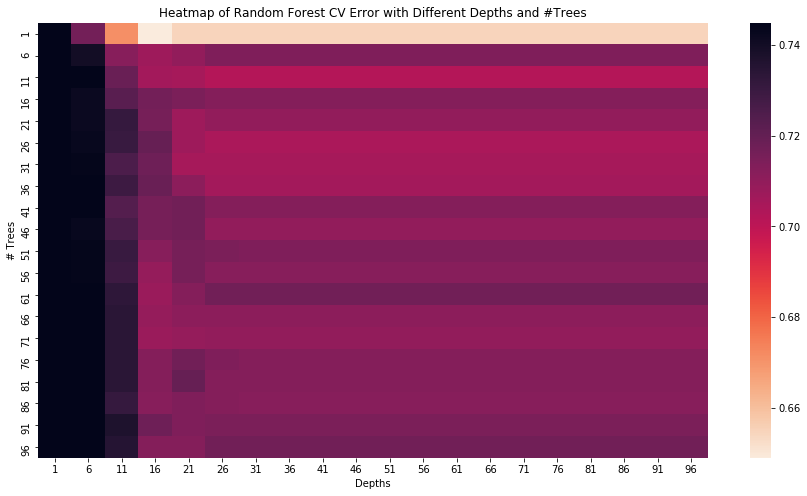

In [78]:
plt.figure(figsize=(15,8))
plot = sns.heatmap(cv_accuracies, cmap = sns.cm.rocket_r, xticklabels=depths, yticklabels=num_trees)
plot.set(title = "Heatmap of Random Forest CV Error with Different Depths and #Trees", xlabel='Depths', ylabel='# Trees')
plt.show()

Looking at this graph, the deeper the color is, the better our cross validation errors are. We realize that to improve our cross validation errors, we have to prune our tree so that it only has a few levels. And for number of trees, as long as the number is less than or equal to 6, the impact it has on the cross validation errors isn't large.

In [79]:
random_forest_best_model = ensemble.RandomForestClassifier(random_state=42, max_depth = best_depth, n_estimators = best_num)
random_forest_best_model.fit(X_train, Y_train)
output_error_and_accuracy_with_fitted_model(random_forest_best_model, X_train, X_test)

model train accuracy: 0.7584869059165859
model test accuracy: 0.755656108597285


Using our tuned random forest model, it once again has no noticable improvement from our base model. Given our model tuning process, we can conclude that both decision tree and random forest have serious problem of overfitting.(Since the cross validation accuracies are highest when depths are lowest) However, pruning them leads them to perform no better than the base model. So there isn't really an ideal solution here. 

### 8. Answering our second set of questions

#### Question 1: What are the factors that best help to classify whether a woman is working? 

Considering both train and test accuracies, our best model so far is our tuned logistic regression model. Let's look at its selected features and corresponding coefficients.

In [80]:
chosen

['wife_age',
 'num_child',
 'wife_education_Junior High',
 'wife_education_Primary School',
 'wife_education_Senior High',
 'husband_education_Junior High',
 'husband_education_Primary School',
 'husband_education_Senior High',
 'wife_religion_Non-Islam']

When run on different servers, because of computational differences after the 5th decimal number when doing cross validation computation, the selected combination of features may differ by a little. However, these differences hardly matter in terms of their influences on the accuracy. The common selected features for our logistic regression model are:
* 1. The education level of the husband.
* 2. The education level of the woman.
* 3. The number of children the woman has.
* 4. Whether the woman's religion is Islamic.
* 5. The age of the woman.

These features are considered the best factors by our model to classify whether a woman is working.

#### Question 2: Can we accurately classify the employment status of a woman based on her other information? 

In [81]:
output_error_and_accuracy_with_fitted_model(best_logistic_model, best_features, X_test_chosen)

model train accuracy: 0.7449078564500485
model test accuracy: 0.7624434389140271


In [82]:
print("base model train accuracy: ", base_model_train_accuracy)
print("base model test accuracy: ", base_model_test_accuracy)

base model train accuracy:  0.7449078564500485
base model test accuracy:  0.7601809954751131


Our best model performs no better than the base model. Previously, when we were examing the confusion matrix generated by the predictions of our best model, we found out that in terms of predictions, our best model performs almost the same as our base model, predicting that all women doesn't work. Under the circumstance, our efforts to classify the employment status of a woman based on her other information is not succcessful. While it certainly is possible that there are existing features that can help us to do classification better. We find it extremely difficult to perform better than a base model with the features at hand.

#### Question 3: If so, what does this tell us about what encourages or discourages a woman from joining the workforce?

Since for our best logistic regression model, the data has been normalized. We can again examine the coefficients given by our model to see the impacts different features have on our predictions.

In [83]:
chosen

['wife_age',
 'num_child',
 'wife_education_Junior High',
 'wife_education_Primary School',
 'wife_education_Senior High',
 'husband_education_Junior High',
 'husband_education_Primary School',
 'husband_education_Senior High',
 'wife_religion_Non-Islam']

In [84]:
best_logistic_model.coef_

array([[ 0.03134519, -0.17063435, -0.34853804, -0.57144079, -0.23680051,
         0.55269103,  0.62102767,  0.27862282,  0.12980363]])

**Considering the fact that our model consistently performs poorly, one theory we have is that none of the features we extracted really had a significant impact on the employment status of women.** Two of the important features selected are husband's education level and a woman's age. We make plots about these two features to show that neither of them really have a significant impact on a woman's employment status.

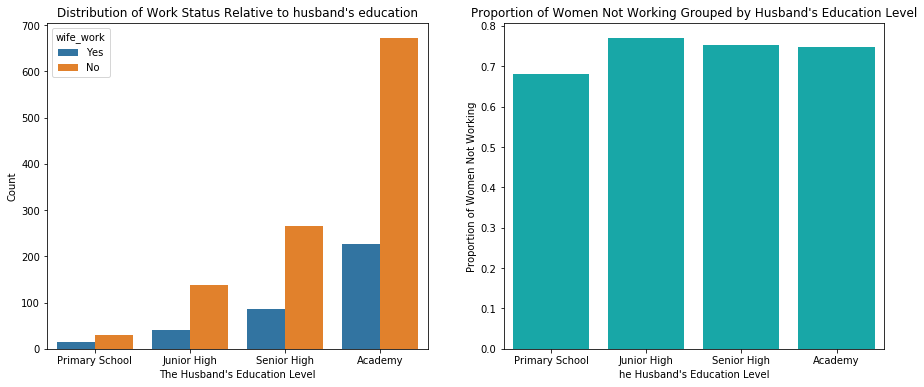

In [85]:
contra_work_prop = contraceptive_original[['husband_education', 'wife_work']].groupby('husband_education').mean()
contra_work_prop = contra_work_prop.rename(columns={'wife_work': 'Prop_Wife_No_Work'}).reset_index()
contra_work_prop = contra_work_prop.replace({'husband_education': {1: "Primary School", 2: "Junior High",
                                              3: "Senior High", 4: "Academy"}})

fig, (ax1, ax2) = plt.subplots(ncols=2,)
fig.set_size_inches(15, 6)
sns.countplot(x="husband_education", order=['Primary School', 'Junior High', 'Senior High', 'Academy'],
                   hue="wife_work", hue_order=['Yes', 'No'], data=contraceptive, ax = ax1)
sns.barplot(x="husband_education", y = "Prop_Wife_No_Work", data = contra_work_prop, color='c', ax = ax2)
ax1.set(xlabel = "The Number of Children Women Have", title = "Distribution of work status relative to number of children",
       ylabel="Number of Women")
ax2.set(xlabel = "The Number of Children Women Have", title = "Distribution of Proportion of Women Working Grouped by Number of Children", 
       ylabel='Proportion of Women Working')
ax1.set(xlabel = "The Husband's Education Level", ylabel='Count', title = "Distribution of Work Status Relative to husband's education")
ax2.set(xlabel = "he Husband's Education Level", title = "Proportion of Women Not Working Grouped by Husband's Education Level", 
       ylabel='Proportion of Women Not Working')
plt.show()

The right plot above shows us the proportion of women who doesn't work for women whose husbands have different education levels. From the plot, we can see that for women whose husbands have different education levels, the proportion of them not working are almost the same. Looking at the plot at left, even though the distribution between different education levels is uneven, the proportion is still almost the same. This tells us that husband's occupation may hardly help to clearly distinguish the data. No wonder why our model performs so poorly!

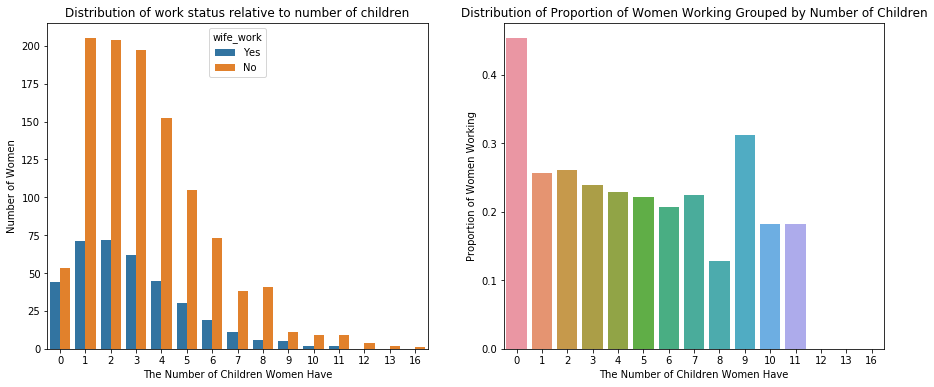

In [86]:
contraceptive_work_prop = contraceptive_encoded[['num_child', 'wife_work_Yes']]
contraceptive_work_prop = contraceptive_work_prop.groupby('num_child').mean().reset_index()

fig, (ax1, ax2) = plt.subplots(ncols=2,)
fig.set_size_inches(15, 6)
sns.countplot(x="num_child", hue="wife_work", hue_order=['Yes', 'No'], data=contraceptive, ax = ax1)
sns.barplot(x="num_child", y="wife_work_Yes", data=contraceptive_work_prop, ax=ax2)
ax1.set(xlabel = "The Number of Children Women Have", title = "Distribution of work status relative to number of children",
       ylabel="Number of Women")
ax2.set(xlabel = "The Number of Children Women Have", title = "Distribution of Proportion of Women Working Grouped by Number of Children", 
       ylabel='Proportion of Women Working')
plt.show()

The right plot above shows us the proportion of women who works for women with different number of children. From the plot, we can see that for women with 1 -7 children, the proportion of them work are almost the same. However, if we look at the left plot above, we can see that most of women in the dataset have 1-7 children. This tells us that even that this important feature may only help to clearly distinguish a small subset of the data. 

***To answer our question, we understand that at least in our sample, no single feature is very useful for predicting whether a woman works. This might tell us that on a societal level in Indonesia, to look for what greatly encourages or discourages a woman form joining the workforce, we can look at more than a woman's age, number of children, education level, husband's education level, and her religion.***

### 9. Future work

Since we failed to produce a good model to classify whether a woman works based on her other information, one important work we can do in the future is to investiage what combination of features work well in this task.<br>
Here's a link I found that might prove helpful: https://ourworldindata.org/female-labor-supply It gives us some inspirations on what would be some good features. For example, average hours of work per week in a woman's community. After coming up with many what we think would be good features, we can find datasets that contain those information, and then build our model again. 
